In [ ]:
# Import the necessary library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
# A. Get the data

# Load the fashion_mnist dataset from TensorFlow
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Store the first 60,000 data samples in train_phuong dictionary
train_phuong = {'images': train_images, 'labels': train_labels}

# Store the next 10,000 data samples in test_phuong dictionary
test_phuong = {'images': test_images, 'labels': test_labels}

# Verify the structure of the stored data by printing the lengths of the arrays
print("Train Images:", len(train_phuong['images']))
print("Train Labels:", len(train_phuong['labels']))
print("Test Images:", len(test_phuong['images']))
print("Test Labels:", len(test_phuong['labels']))

Train Images: 60000
Train Labels: 60000
Test Images: 10000
Test Labels: 10000


In [ ]:
# B. Data Pre-processing

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.
train_images = np.expand_dims(train_images, -1)

test_images = test_images.astype('float32') / 255.
test_images = np.expand_dims(test_images, -1)

# Create a dictionary 'supervised_phuong' to hold normalized training images and their labels
supervised_phuong = {'images': train_images, 'labels': train_labels}
# Create a dictionary 'unsupervised_phuong' to hold normalized testing images and their labels
unsupervised_phuong = {'images': test_images, 'labels': test_labels}

# Print the shape of the images in supervised_phuong and unsupervised_phuong
print("Shape of supervised_phuong['images']:", supervised_phuong['images'].shape)
print("Shape of unsupervised_phuong['images']:", unsupervised_phuong['images'].shape)

Shape of supervised_phuong['images']: (60000, 28, 28, 1)
Shape of unsupervised_phuong['images']: (10000, 28, 28, 1)


In [ ]:
# C. Build Variational Autoencoder with latent dimension size of 2

# 1. Define a custom layer for sampling from the latent space
class SampleLayer(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z_phuong = mean + tf.exp(0.5 * log_var) * epsilon
        return z_phuong

In [ ]:
# 2. Load and preprocess the dataset

# Define the input layer of the encoder model
input_img = layers.Input(shape=(28, 28, 1))

# Stack of Convolutional layers with ReLU activations and padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Flatten the output to feed into a dense layer
x = layers.Flatten()(x)

# Dense layer for feature extraction
x = layers.Dense(32, activation='relu')(x)

# Layers to output the mean and log variance of the latent space distribution
z_mu_phuong = layers.Dense(2)(x)
z_log_sigma_phuong = layers.Dense(2)(x)

# Sampling layer
z_phuong = SampleLayer()([z_mu_phuong, z_log_sigma_phuong])

# Create the encoder model
encoder = Model(input_img, [z_mu_phuong, z_log_sigma_phuong, z_phuong], name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

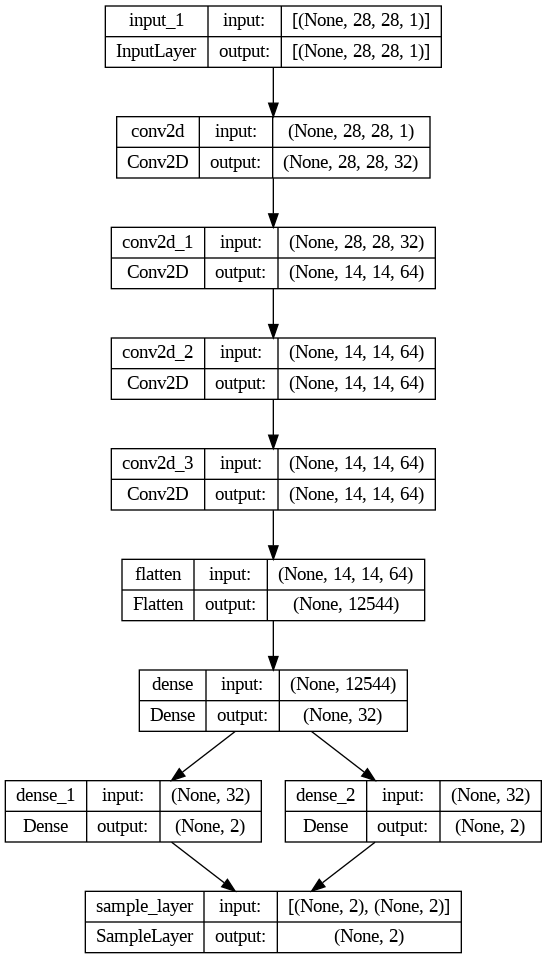

In [ ]:
# 3. Print the encoder model's summary and visualize its architecture
encoder.summary()
plot_model(encoder, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# 4. Define the decoder network

decoder_input = layers.Input(shape=(2,))
x = layers.Dense(14 * 14 * 64, activation='relu')(decoder_input)
x = layers.Reshape((14, 14, 64))(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Instantiate the decoder model
decoder_phuong = Model(decoder_input, decoded_output, name="decoder")

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 32)        18464     
 anspose)                                                        
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 1)         289       
                                                                 
Total params: 56385 (220.25 KB)
Trainable params: 56385 (220.25 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

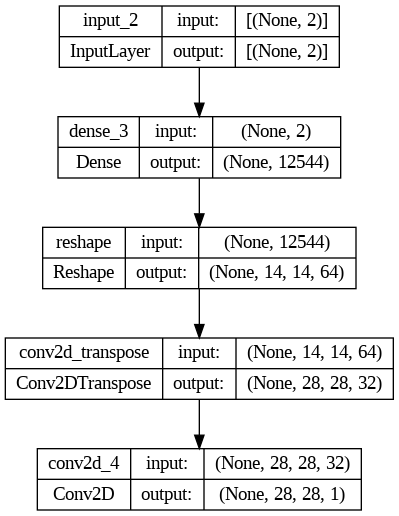

In [ ]:
# 5. Display a summary of the decoder model to verify its architecture

decoder_phuong.summary()
plot_model(decoder_phuong, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# 6. Combine encoder and decoder to build the VAE model

# Use the encoder to get the mean, log variance, and sampled latent vector
z_mu_phuong, z_log_sigma_phuong, z_phuong = encoder(input_img)

# VAE model
outputs = decoder_phuong(z_phuong)
vae_phuong = Model(inputs=input_img, outputs=outputs, name="vae_phuong")

Model: "vae_phuong"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               494244    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56385     
                                                                 
Total params: 550629 (2.10 MB)
Trainable params: 550629 (2.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


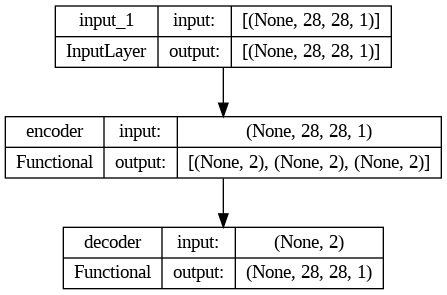

In [ ]:
# 7. Display a summary of the complete VAE model
vae_phuong.summary()

# Visualize the VAE model architecture
plot_model(vae_phuong, to_file='vae_phuong_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# D. Define the KL divergence loss as an additional loss term
kl_loss = -0.5 * tf.reduce_mean(z_mu_phuong - tf.square(z_mu_phuong) - tf.exp(z_log_sigma_phuong) + 1)

In [ ]:
# E. Add the KL divergence loss to the VAE model
vae_phuong.add_loss(kl_loss)

In [ ]:
# F. Compile the VAE model
vae_phuong.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# # G. Train the VAE
# if len(train_phuong['images'].shape) == 3:
#     train_images_reshaped = np.expand_dims(train_phuong['images'], -1)
# else:
#     train_images_reshaped = train_phuong['images']

# # Train the VAE
# history = vae_phuong.fit(
#     train_images_reshaped,
#     train_images_reshaped,
#     epochs=10,
#     batch_size=256,
#     validation_split=0.2
# )

In [ ]:
# G. Normalize and reshape the dataset if necessary

# Normalize training images to have values between 0 and 1
train_images = train_phuong['images'].astype('float32') / 255.0

if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, -1)

# Train the model
history = vae_phuong.fit(
    train_images,
    train_images,
    epochs=10,
    batch_size=256
)

Epoch 1/10
235/235 [==============================] - 16s 23ms/step - loss: -0.5029
Epoch 2/10
235/235 [==============================] - 5s 22ms/step - loss: -0.5488
Epoch 3/10
235/235 [==============================] - 5s 21ms/step - loss: -0.5657
Epoch 4/10
235/235 [==============================] - 5s 21ms/step - loss: -0.5706
Epoch 5/10
235/235 [==============================] - 5s 21ms/step - loss: -0.5737
Epoch 6/10
235/235 [==============================] - 5s 21ms/step - loss: -0.5754
Epoch 7/10
235/235 [==============================] - 5s 22ms/step - loss: -0.5768
Epoch 8/10
235/235 [==============================] - 5s 21ms/step - loss: -0.5777
Epoch 9/10
235/235 [==============================] - 5s 22ms/step - loss: -0.5786
Epoch 10/10
235/235 [==============================] - 5s 21ms/step - loss: -0.5791


1/1 [==============================] - 0s 28ms/step


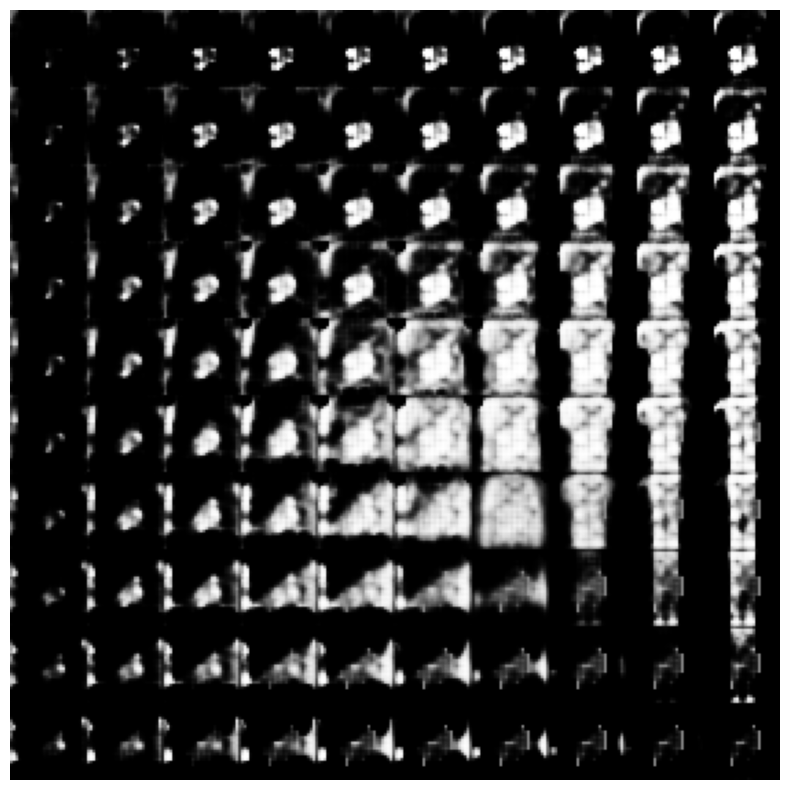

In [ ]:
# H. Generate images from the latent space and display them in a grid
# Set the grid size to 10x10 and figure size
n = 10
figure_size = 28

# Create a normal distribution object for generating values in the latent space
norm = tfp.distributions.Normal(0, 1)

# Generate evenly spaced percentiles from the normal distribution
grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
grid_y = norm.quantile(np.linspace(0.05, 0.95, n))

# Initialize a figure to hold the generated images
figure = np.zeros((figure_size * n, figure_size * n))

# Fill the figure array with images generated from latent space coordinates
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z = np.array([[xi, yi]])
        x_decoded = decoder_phuong.predict(z)
        img = x_decoded[0].reshape(figure_size, figure_size)
        figure[i * figure_size: (i + 1) * figure_size,
               j * figure_size: (j + 1) * figure_size] = img

# Display the generated images as a 10x10 grid
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()

313/313 [==============================] - 1s 2ms/step


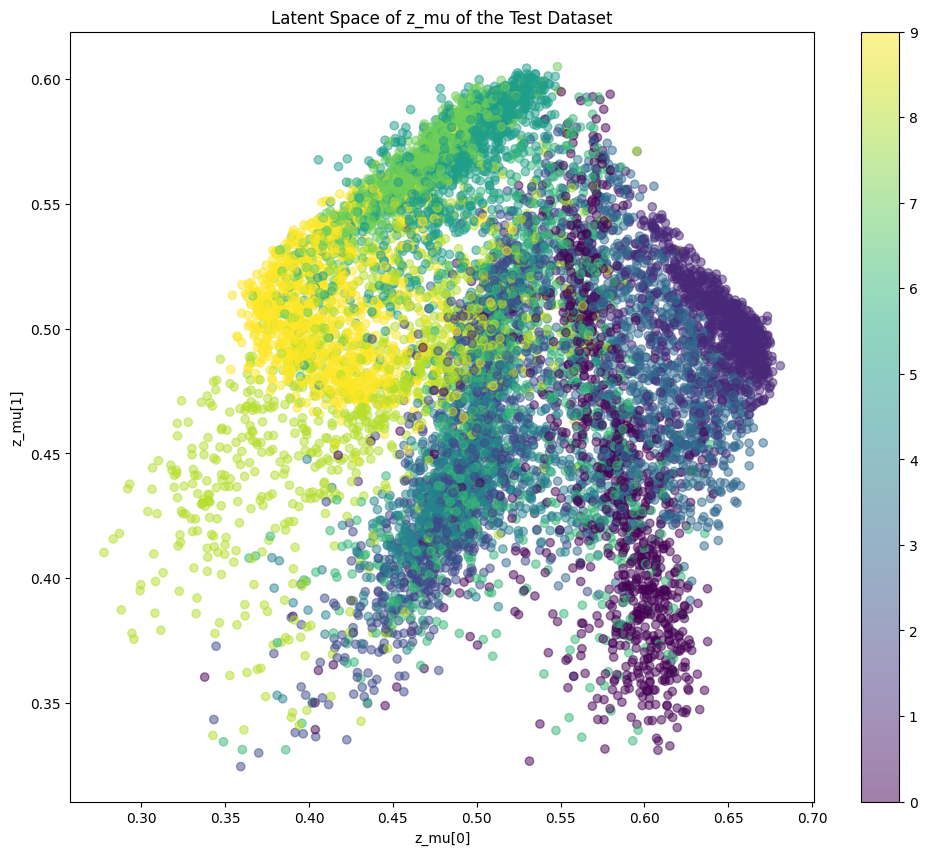

In [ ]:
# I. Visualize the latent space

# Create a model that outputs only z_mu_phuong
z_mu_model = Model(inputs=encoder.input, outputs=z_mu_phuong)

# Predict the z_mu values for test images
test_images_reshaped = np.expand_dims(test_phuong['images'], -1).astype('float32') / 255.0
z_mu_test = z_mu_model.predict(test_images_reshaped)

# Scatter plot of the latent variables colored by their true labels
plt.figure(figsize=(12, 10))
plt.scatter(z_mu_test[:, 0], z_mu_test[:, 1], c=test_phuong['labels'], alpha=0.5, cmap='viridis')
plt.colorbar()
plt.xlabel('z_mu[0]')
plt.ylabel('z_mu[1]')
plt.title('Latent Space of z_mu of the Test Dataset')
plt.show()